# Imports

In [1]:
import sys
sys.path.append('/home/student/project/HumanChoicePrediction/')

In [2]:
import pandas as pd
from consts import N_HOTELS
import glob
import nltk 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import opinion_lexicon
from nltk.tokenize import treebank
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
nltk.download('vader_lexicon')
nltk.download('opinion_lexicon')
nltk.download('punkt')

pd.options.mode.chained_assignment = None

/anaconda/envs/final_project_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/student/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
RANDOM_STATE = 42

# Functions

In [4]:
def find_nearest(array, value):
    """
    Find the index and value of the nearest element in an array to a given value.

    Args:
        array (array-like): The array to search.
        value (float): The value to find the nearest element to.

    Returns:
        tuple: A tuple containing the index of the nearest element and the nearest element itself (idx, nearest_value).
    """
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]


def get_sentiment_scores_vectorized(reviews):
    """
    Calculate the positive and negative sentiment scores for a list of reviews.

    Args:
        reviews (list of str): List of review texts to be analyzed.

    Returns:
        pd.DataFrame: DataFrame containing positive and negative sentiment scores.
    """
    analyzer = SentimentIntensityAnalyzer()
    # Apply the sentiment analysis to each review
    scores = [analyzer.polarity_scores(review) for review in reviews]
    # Extract positive and negative scores
    positive_scores = [score['pos'] for score in scores]
    negative_scores = [score['neg'] for score in scores]
    return pd.DataFrame({'concat_positive_score': positive_scores, 'concat_negative_score': negative_scores})

def get_positive_negative_neutral_counts(sentence):
    """
    Count the number of positive, negative, and neutral words in a sentence.

    Args:
        sentence (str): The sentence to be analyzed.

    Returns:
        tuple: A tuple containing counts of positive, negative, and neutral words (pos_words, neg_words, neu_words).
    """
    tokenizer = treebank.TreebankWordTokenizer()
    pos_words = 0
    neg_words = 0
    neu_words = 0
    tokenized_sent = [word.lower() for word in tokenizer.tokenize(sentence)]

    for word in tokenized_sent:
        if word in opinion_lexicon.positive():
            pos_words += 1
        elif word in opinion_lexicon.negative():
            neg_words += 1
        else:
            neu_words +=1

    return pos_words, neg_words, neu_words


# Analysis based on Trip Advisor hotel reviews

## Load reviews

In [5]:
df_training = pd.read_csv('/home/student/project/HumanChoicePrediction/data/tripadvisor_hotel_reviews.csv')
# get scores out of 10 instead of 5
df_training['Rating'] = df_training['Rating'] * 2
df_training

,Review,Rating
0,nice hotel expensive parking got good deal sta...,8
1,ok nothing special charge diamond member hilto...,4
2,nice rooms not 4* experience hotel monaco seat...,6
3,"unique, great stay, wonderful time hotel monac...",10
4,"great stay great stay, went seahawk game aweso...",10
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",10
20487,great location price view hotel great quick pl...,8
20488,"ok just looks nice modern outside, desk staff ...",4
20489,hotel theft ruined vacation hotel opened sept ...,2


## Calculate sentiment scores for each review

In [6]:
results_df = get_sentiment_scores_vectorized(df_training['Review'])
results_df.head()

,concat_positive_score,concat_negative_score
0,0.285,0.072
1,0.189,0.110
2,0.219,0.081
3,0.385,0.060
4,0.221,0.135


Define good review, good to bad ratio and handle infinite results

In [7]:
df_training[['positive_score', 'negative_score']] = results_df
df_training['positive_to_negative_sentiment_ratio']= df_training['positive_score']/df_training['negative_score']
# "good review" is a review that the score is greater or equal to 8
df_training['is_good_review'] = (df_training['Rating']>=8).astype(int)
# Handle the case negative review score is 0.0 and positive review is greater than 0.0. change inf values to high numeric value.
df_training['positive_to_negative_sentiment_ratio'] = df_training['positive_to_negative_sentiment_ratio'].replace([np.inf], 100)
# Drop rows that didn't get positive\negative scores greater than 0.0.
df_training = df_training.dropna()
df_training.head()

,Review,Rating,positive_score,negative_score,positive_to_negative_sentiment_ratio,is_good_review
0,nice hotel expensive parking got good deal sta...,8,0.285,0.072,3.958333,1
1,ok nothing special charge diamond member hilto...,4,0.189,0.110,1.718182,0
2,nice rooms not 4* experience hotel monaco seat...,6,0.219,0.081,2.703704,0
3,"unique, great stay, wonderful time hotel monac...",10,0.385,0.060,6.416667,1
4,"great stay great stay, went seahawk game aweso...",10,0.221,0.135,1.637037,1


Check how the ratio behave vs. the positive score

<Axes: >

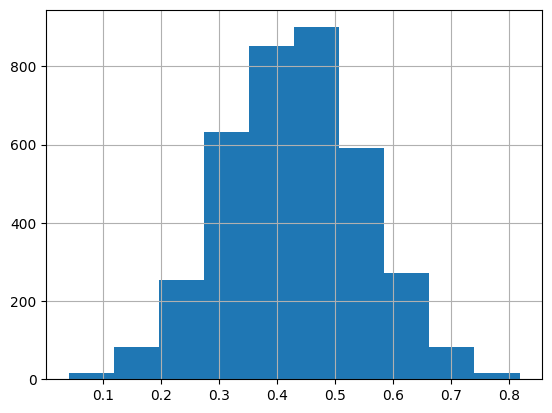

In [8]:
df_training.loc[df_training['positive_to_negative_sentiment_ratio']==100.0, 'positive_score'].hist()

## Split to X, y for ration threshold analysis

In [9]:
X, y = df_training.drop(['is_good_review'],axis=1), df_training['is_good_review']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=RANDOM_STATE)

## Check precision-recall curve as we want to emphasis more weight on positive targets

### Find ratio Threshold from training dataset

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


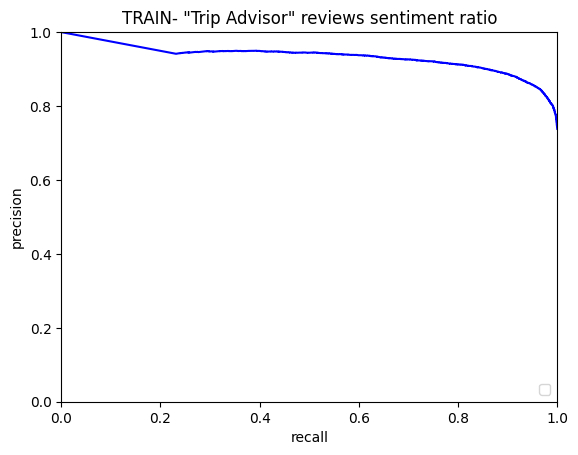

In [11]:
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, X_train['positive_to_negative_sentiment_ratio'])


plt.title('TRAIN- "Trip Advisor" reviews sentiment ratio')
plt.plot( recall_train, precision_train, 'b',)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

Find the nearest idx for required recall point

In [12]:
required_recall = 0.85
opt_idx, recall_value = find_nearest(recall_train, required_recall)
opt_train_threshold = thresholds_train[opt_idx]
print(f"Required Recall: {required_recall}")
print(f"Optimal Index: {opt_idx}")
print(f"Recall at Optimal Index: {recall_value:.4f}")
print(f"Precision at Optimal Index: {precision_train[opt_idx]:.4f}")
print(f"Threshold at Optimal Index: {thresholds_train[opt_idx]:.4f}")

Required Recall: 0.85
Optimal Index: 3667
Recall at Optimal Index: 0.8500
Precision at Optimal Index: 0.9022
Threshold at Optimal Index: 2.8469


### Validating ratio threshold on test dataset

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


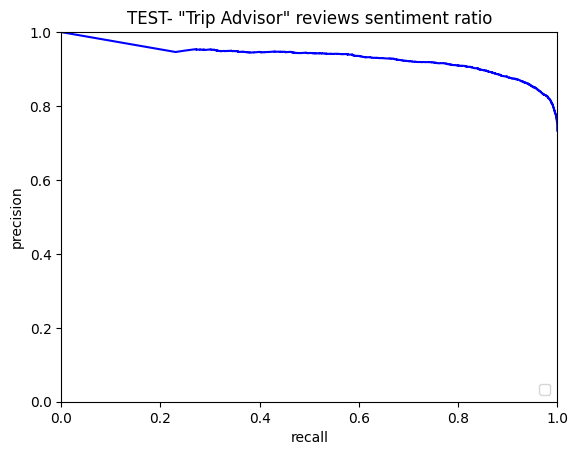

In [13]:
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, X_test['positive_to_negative_sentiment_ratio'])

plt.title('TEST- "Trip Advisor" reviews sentiment ratio')
plt.plot( recall_test, precision_test, 'b',)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

Check precision and recall values based on threshold from train

In [14]:
idx_th, th_value = find_nearest(thresholds_test, opt_train_threshold)
idx_th, th_value, recall_test[idx_th], precision_test[idx_th]
print(f"Required Threshold: {opt_train_threshold}")
print(f"Threshold Index: {idx_th}")
print(f"Recall at Threshold Index: {recall_test[idx_th]:.4f}")
print(f"Precision at Threshold Index: {precision_test[idx_th]:.4f}")
print(f"Threshold at Threshold Index: {thresholds_test[idx_th]:.4f}")

Required Threshold: 2.8469387755102042
Threshold Index: 1924
Recall at Threshold Index: 0.8498
Precision at Threshold Index: 0.8974
Threshold at Threshold Index: 2.8462


In [15]:
positive_to_negative_sentiment_ratio_threshold = 2.8469387755102042

# Analysis based on Booking hotel reviews

## Load Booking reviews

In [16]:
file_paths = glob.glob('/home/student/project/HumanChoicePrediction/data/game_reviews/*.csv')
file_paths

['/home/student/project/HumanChoicePrediction/data/game_reviews/991.csv',
 '/home/student/project/HumanChoicePrediction/data/game_reviews/340.csv',
 '/home/student/project/HumanChoicePrediction/data/game_reviews/1013.csv',
 '/home/student/project/HumanChoicePrediction/data/game_reviews/521.csv',
 '/home/student/project/HumanChoicePrediction/data/game_reviews/438.csv',
 '/home/student/project/HumanChoicePrediction/data/game_reviews/480.csv',
 '/home/student/project/HumanChoicePrediction/data/game_reviews/28.csv',
 '/home/student/project/HumanChoicePrediction/data/game_reviews/1057.csv',
 '/home/student/project/HumanChoicePrediction/data/game_reviews/594.csv',
 '/home/student/project/HumanChoicePrediction/data/game_reviews/741.csv',
 '/home/student/project/HumanChoicePrediction/data/game_reviews/857.csv',
 '/home/student/project/HumanChoicePrediction/data/game_reviews/315.csv',
 '/home/student/project/HumanChoicePrediction/data/game_reviews/570.csv',
 '/home/student/project/HumanChoicePr

### Create dataframe with sentiment analysis per review

In [17]:
sia = SentimentIntensityAnalyzer()

data_frames = []

for file_path in file_paths:
    df = pd.read_csv(file_path, header=None)
    selected_columns = df[[0, 2, 3, 4]]    
    selected_columns.columns = ['ID', 'positive_review', 'negative_review','rating']       
    data_frames.append(selected_columns)


combined_df = pd.concat(data_frames, ignore_index=True)
combined_df['concat_review'] = combined_df['positive_review'].astype(str) + ". " + combined_df['negative_review'].astype(str)
results_df = get_sentiment_scores_vectorized(combined_df['concat_review'].astype(str))
combined_df[['positive_score', 'negative_score']] = results_df

combined_df.head()

,ID,positive_review,negative_review,rating,concat_review,positive_score,negative_score
0,2411,Very nice room,Not too much choice for breakfast and the swim...,6.0,Very nice room. Not too much choice for breakf...,0.171,0.000
1,2272,Top facilities,Heating didn't work. It was warmer after I swi...,8.3,Top facilities. Heating didn't work. It was wa...,0.095,0.000
2,2561,NaN,Badly maintained hotel many switches not funct...,6.3,nan. Badly maintained hotel many switches not ...,0.000,0.242
3,1321,"Beautiful little balconette, gorgeous bathroom...","A few little stains, no coffee machine and emp...",8.0,"Beautiful little balconette, gorgeous bathroom...",0.355,0.116
4,1639,"Everything was good, location was good for sho...",Everything was comforting,10.0,"Everything was good, location was good for sho...",0.451,0.000


Calculate ratio and data preproccessing

In [18]:
combined_df['positive_to_negative_sentiment_ratio']= combined_df['positive_score']/combined_df['negative_score']
combined_df['is_good_review'] = (combined_df['rating']>=8).astype(int)
combined_df['positive_to_negative_sentiment_ratio'] = combined_df['positive_to_negative_sentiment_ratio'].replace([np.inf], 100)
combined_df['positive_to_negative_sentiment_ratio'] = combined_df['positive_to_negative_sentiment_ratio'].replace([np.nan], 0)

combined_df.head()

,ID,positive_review,negative_review,rating,concat_review,positive_score,negative_score,positive_to_negative_sentiment_ratio,is_good_review
0,2411,Very nice room,Not too much choice for breakfast and the swim...,6.0,Very nice room. Not too much choice for breakf...,0.171,0.000,100.000000,0
1,2272,Top facilities,Heating didn't work. It was warmer after I swi...,8.3,Top facilities. Heating didn't work. It was wa...,0.095,0.000,100.000000,1
2,2561,NaN,Badly maintained hotel many switches not funct...,6.3,nan. Badly maintained hotel many switches not ...,0.000,0.242,0.000000,0
3,1321,"Beautiful little balconette, gorgeous bathroom...","A few little stains, no coffee machine and emp...",8.0,"Beautiful little balconette, gorgeous bathroom...",0.355,0.116,3.060345,1
4,1639,"Everything was good, location was good for sho...",Everything was comforting,10.0,"Everything was good, location was good for sho...",0.451,0.000,100.000000,1


Check how the extreme ratio behave vs. the positive score

<Axes: >

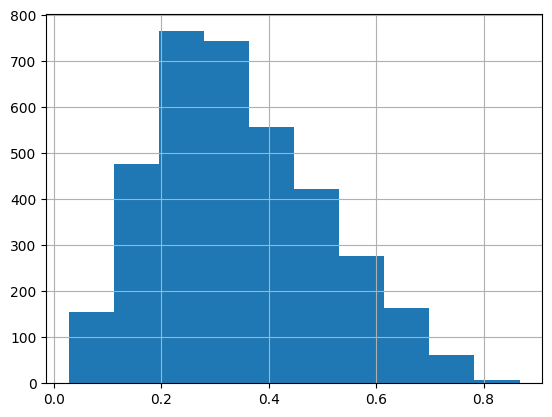

In [19]:
combined_df.loc[combined_df['positive_to_negative_sentiment_ratio']==100.0, 'positive_score'].hist()

In [20]:
X, y = combined_df.drop(['is_good_review'],axis=1), combined_df['is_good_review']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


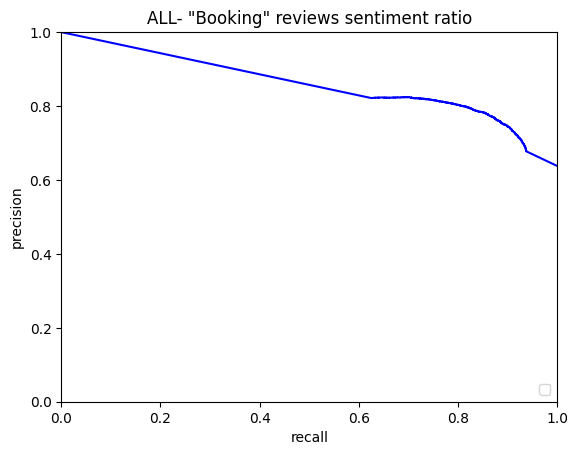

In [21]:
precision_all, recall_all, thresholds_all = precision_recall_curve(y, X['positive_to_negative_sentiment_ratio'])

plt.title('ALL- "Booking" reviews sentiment ratio')
plt.plot( recall_all, precision_all, 'b',)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

We see a bit of degradation in precision in our results based, but expected due to the different precision-recall curve:

In [22]:
idx_th, th_value = find_nearest(thresholds_all, opt_train_threshold)
idx_th, th_value, recall_all[idx_th], precision_all[idx_th]
print(f"Required Threshold: {opt_train_threshold}")
print(f"Threshold Index: {idx_th}")
print(f"Recall at Threshold Index: {recall_all[idx_th]:.4f}")
print(f"Precision at Threshold Index: {precision_all[idx_th]:.4f}")
print(f"Threshold at Threshold Index: {thresholds_all[idx_th]:.4f}")

Required Threshold: 2.8469387755102042
Threshold Index: 1602
Recall at Threshold Index: 0.8125
Precision at Threshold Index: 0.7991
Threshold at Threshold Index: 2.8478


## Analysis of positive to negative reviews length ratio

In [23]:
combined_df['positive_review_length'] = combined_df['positive_review'].apply(lambda x: len(nltk.word_tokenize(str(x))))
combined_df['negative_review_length'] = combined_df['negative_review'].apply(lambda x: len(nltk.word_tokenize(str(x))))
combined_df['positive_to_negative_length_ratio']= combined_df['positive_review_length']/combined_df['negative_review_length']
combined_df['review_length'] = combined_df['concat_review'].apply(lambda x: len(nltk.word_tokenize(str(x))))
combined_df.head()

,ID,positive_review,negative_review,rating,concat_review,positive_score,negative_score,positive_to_negative_sentiment_ratio,is_good_review,positive_review_length,negative_review_length,positive_to_negative_length_ratio,review_length
0,2411,Very nice room,Not too much choice for breakfast and the swim...,6.0,Very nice room. Not too much choice for breakf...,0.171,0.000,100.000000,0,3,13,0.230769,17
1,2272,Top facilities,Heating didn't work. It was warmer after I swi...,8.3,Top facilities. Heating didn't work. It was wa...,0.095,0.000,100.000000,1,2,50,0.040000,53
2,2561,NaN,Badly maintained hotel many switches not funct...,6.3,nan. Badly maintained hotel many switches not ...,0.000,0.242,0.000000,0,1,18,0.055556,20
3,1321,"Beautiful little balconette, gorgeous bathroom...","A few little stains, no coffee machine and emp...",8.0,"Beautiful little balconette, gorgeous bathroom...",0.355,0.116,3.060345,1,15,13,1.153846,28
4,1639,"Everything was good, location was good for sho...",Everything was comforting,10.0,"Everything was good, location was good for sho...",0.451,0.000,100.000000,1,25,3,8.333333,28


Save dataframe after all needed information is gained:

In [24]:
combined_df.to_csv('/home/student/project/HumanChoicePrediction/data/combined_reviews_with_sentiment_scores.csv', index=False)

Split into train&test datasets

In [25]:
X, y = combined_df.drop(['is_good_review'],axis=1), combined_df['is_good_review']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=RANDOM_STATE)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


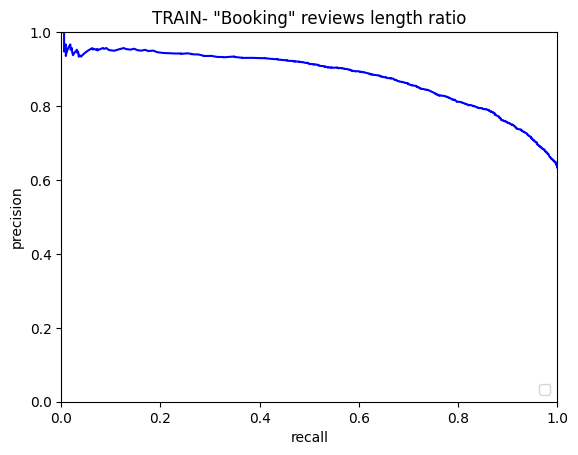

In [26]:
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, X_train['positive_to_negative_length_ratio'])

plt.title('TRAIN- "Booking" reviews length ratio')
plt.plot( recall_train, precision_train, 'b',)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

In [27]:
required_recall = 0.80
opt_idx, recall_value = find_nearest(recall_train, required_recall)
opt_train_threshold = thresholds_train[opt_idx]
print(f"Required Recall: {required_recall}")
print(f"Optimal Index: {opt_idx}")
print(f"Recall at Optimal Index: {recall_value:.4f}")
print(f"Precision at Optimal Index: {precision_train[opt_idx]:.4f}")
print(f"Threshold at Optimal Index: {thresholds_train[opt_idx]}")

Required Recall: 0.8
Optimal Index: 675
Recall at Optimal Index: 0.7997
Precision at Optimal Index: 0.8114
Threshold at Optimal Index: 0.7878787878787878


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


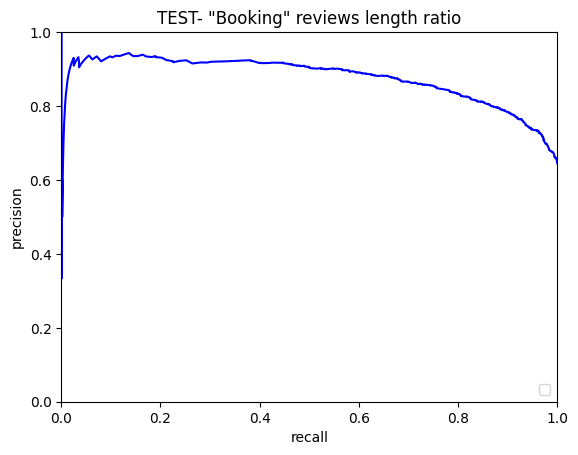

In [28]:
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, X_test['positive_to_negative_length_ratio'])

plt.title('TEST- "Booking" reviews length ratio')
plt.plot( recall_test, precision_test, 'b',)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

In [29]:
idx_th, th_value = find_nearest(thresholds_test, opt_train_threshold)
idx_th, th_value, recall_test[idx_th], precision_test[idx_th]
print(f"Required Threshold: {opt_train_threshold}")
print(f"Threshold Index: {idx_th}")
print(f"Recall at Threshold Index: {recall_test[idx_th]:.4f}")
print(f"Precision at Threshold Index: {precision_test[idx_th]:.4f}")
print(f"Threshold at Threshold Index: {thresholds_test[idx_th]:.4f}")

Required Threshold: 0.7878787878787878
Threshold Index: 410
Recall at Threshold Index: 0.8236
Precision at Threshold Index: 0.8226
Threshold at Threshold Index: 0.7917


In [30]:
good_to_bad_length_ratio_threshold = 0.7878787878787878

# Ratios results:

In [31]:
print(f"Positive to Negative Sentiment Ratio Threshold: {positive_to_negative_sentiment_ratio_threshold}")
print(f"Positive to Negative Length Ratio Threshold: {good_to_bad_length_ratio_threshold}")

Positive to Negative Sentiment Ratio Threshold: 2.8469387755102042
Positive to Negative Length Ratio Threshold: 0.7878787878787878
